## Importing Python packages

- *matplotlib* provides plotting functions
- *skimage* represents scikit-image, which provides several useful image manipulation tools
- *boto3* represents the AWS SDK for Python (Boto3), which is the Python library for AWS
- *numpy* represents NumPy, which is a library for manipulating data
- *PIL* represents the Python Imaging Library, which contains a set of tools for drawing images


In [1]:
from skimage import io
from skimage.transform import rescale
from matplotlib import pyplot as plt

import boto3

import numpy as np

from PIL import Image, ImageDraw, ImageColor, ImageOps


Creating a collection in Amazon Rekognition.


In [2]:
client = boto3.client('rekognition')
collection_id = 'Collection'
try:
    response = client.create_collection(CollectionId=collection_id)
    print('Collection ARN: ' + response['CollectionArn'])
    print('Status Code:' + str(response['StatusCode']))
    print('Done...')
except client.exceptions.ResourceAlreadyExistsException:
    print('Collection already exists')


Collection already exists


Uploading an image to be searched



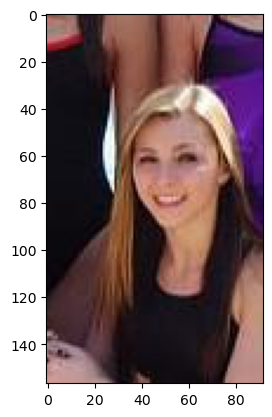

In [3]:

# Task 2: Uploading an image to search
filename = "test3.jpg"
faceimage = io.imread(filename)
plt.imshow(faceimage)
plt.show()


## Adding the image to the collection



In [4]:
# Task 3: Adding the image to the collection
externalimageid = filename

with open(filename, 'rb') as fimage:
    response = client.index_faces(
        CollectionId=collection_id,
        Image={'Bytes': fimage.read()},
        ExternalImageId=externalimageid,
        MaxFaces=6,  # Set the desired maximum number of faces to detect (e.g., 6)
        QualityFilter="AUTO",
        DetectionAttributes=['ALL']
    )

print('Results for ' + filename)
print('Faces indexed:')
for faceRecord in response['FaceRecords']:
    print('  Face ID: ' + faceRecord['Face']['FaceId'])
    print('  Location: {}'.format(faceRecord['Face']['BoundingBox']))

print('Faces not indexed:')
for unindexedFace in response['UnindexedFaces']:
    print(' Location: {}'.format(unindexedFace['FaceDetail']['BoundingBox']))
    print(' Reasons:')
    for reason in unindexedFace['Reasons']:
        print('   ' + reason)


Results for test3.jpg
Faces indexed:
  Face ID: b6b38d18-640d-401a-ad41-4b018ec9daae
  Location: {'Width': 0.3843243718147278, 'Height': 0.3093039095401764, 'Left': 0.40010759234428406, 'Top': 0.2749554216861725}
Faces not indexed:


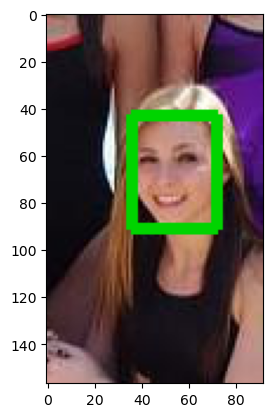

In [5]:
#Viewing the bounding box for the detected faces
img = Image.open(filename)
imgWidth, imgHeight = img.size

draw = ImageDraw.Draw(img)
for faceRecord in response['FaceRecords']:
    box = faceRecord['Face']['BoundingBox']
    left = imgWidth * box['Left']
    top = imgHeight * box['Top']
    width = imgWidth * box['Width']
    height = imgHeight * box['Height']

    points = ((left, top), (left + width, top), (left + width, top + height),
              (left, top + height), (left, top))

    draw.line(points, fill='#00d400', width=5)

plt.imshow(img)
plt.show()

## Viewing the bounding box for the detected face


Using the PIL library  By extracting the BoundingBox to draw border or line around the face 


In [6]:
# Rescale the image if it's larger than 4096 x 4096 pixels
max_size = 4096
if max(faceimage.shape) > max_size:
    scale_factor = max_size / max(faceimage.shape)
    faceimage = rescale(faceimage, scale_factor, mode='constant')

io.imsave(filename, faceimage)

with open(filename, 'rb') as fimage:
    response = client.index_faces(
        CollectionId=collection_id,
        Image={'Bytes': fimage.read()},
        ExternalImageId=externalimageid,
        MaxFaces=1,
        QualityFilter="AUTO",
        DetectionAttributes=['ALL']
    )

print('Results for ' + filename)
print('Faces indexed:')
for faceRecord in response['FaceRecords']:
    print('  Face ID: ' + faceRecord['Face']['FaceId'])
    print('  Location: {}'.format(faceRecord['Face']['BoundingBox']))


Results for test3.jpg
Faces indexed:
  Face ID: 69200ae1-300c-4d4e-88a2-0826efb88ec9
  Location: {'Width': 0.38434135913848877, 'Height': 0.3093297481536865, 'Left': 0.40010619163513184, 'Top': 0.2749292552471161}


In [7]:

# Listing faces in the collection
maxResults = 2
faces_count = 0
tokens = True

response = client.list_faces(CollectionId=collection_id, MaxResults=maxResults)

print('Faces in collection ' + collection_id)

while tokens:
    faces = response['Faces']

    for face in faces:
        print(face)
        faces_count += 1

    if 'NextToken' in response:
        nextToken = response['NextToken']
        response = client.list_faces(CollectionId=collection_id, NextToken=nextToken, MaxResults=maxResults)
    else:
        tokens = False


Faces in collection Collection
{'FaceId': '000f2c26-12c1-4c5c-9209-2c9c2931f741', 'BoundingBox': {'Width': 0.14052699506282806, 'Height': 0.27836498618125916, 'Left': 0.28922098875045776, 'Top': 0.15921300649642944}, 'ImageId': 'bc5e8d0d-1c6e-3972-8b97-f5bb25e1e467', 'ExternalImageId': 'test1.jpg', 'Confidence': 99.99649810791016, 'IndexFacesModelVersion': '6.0'}
{'FaceId': '02fa29a5-92ac-4904-a2fd-3de72dc3dd3a', 'BoundingBox': {'Width': 0.05510669946670532, 'Height': 0.0930090993642807, 'Left': 0.6759179830551147, 'Top': 0.08929689973592758}, 'ImageId': '39ac0af6-4349-3726-879d-7c5421084abb', 'ExternalImageId': 'test2.jpg', 'Confidence': 99.99150085449219, 'IndexFacesModelVersion': '6.0'}
{'FaceId': '0380af36-c4f4-486e-9a9e-3d657116dbff', 'BoundingBox': {'Width': 0.05776200070977211, 'Height': 0.09622830152511597, 'Left': 0.3369710147380829, 'Top': 0.5388249754905701}, 'ImageId': '5350f93a-7cf9-3cc7-8855-557a06953176', 'ExternalImageId': 'test2.jpg', 'Confidence': 99.9708023071289, 'I

In [8]:
#detect emotions based on facial expressions 
with open(filename, 'rb') as fimage:
    response = client.index_faces(
        CollectionId=collection_id,
        Image={'Bytes': fimage.read()},
        ExternalImageId=externalimageid,
        MaxFaces=1,
        QualityFilter="AUTO",
        DetectionAttributes=['ALL']
    )

    fimage.seek(0)  # Reset the file pointer to the beginning
    response_faces = client.detect_faces(
        Image={'Bytes': fimage.read()},
        Attributes=['ALL']
    )

for faceRecord in response_faces['FaceDetails']:
    emotions = faceRecord['Emotions']
    print('Emotions detected:')
    for emotion in emotions:
        print('  Type: ' + emotion['Type'])
        print('  Confidence: ' + str(emotion['Confidence']))


Emotions detected:
  Type: HAPPY
  Confidence: 99.89300537109375
  Type: SURPRISED
  Confidence: 6.266785621643066
  Type: FEAR
  Confidence: 5.87691593170166
  Type: SAD
  Confidence: 2.1517152786254883
  Type: CONFUSED
  Confidence: 0.02259313315153122
  Type: ANGRY
  Confidence: 0.011420699767768383
  Type: CALM
  Confidence: 0.011143306270241737
  Type: DISGUSTED
  Confidence: 0.009889598935842514


Listing faces in the collection




In [9]:
threshold = 70
maxFaces=2

with open(targetfilename, 'rb') as timage:        
    response2=client.search_faces_by_image(CollectionId=collection_id,
                            Image={'Bytes': timage.read()},
                            FaceMatchThreshold=threshold,
                            MaxFaces=maxFaces)

faceMatches=response2['FaceMatches']
print ('Matching faces')
for match in faceMatches:
        print ('FaceId:' + match['Face']['FaceId'])
        print ('Similarity: ' + "{:.2f}".format(match['Similarity']) + "%")
        print ('ExternalImageId: ' + match['Face']['ExternalImageId'])
        

NameError: name 'targetfilename' is not defined

## Finding a face by using the collection
upload target image that is test2 and detect the test1 image 


In [14]:
targetfilename = "test2.jpg"
timage = open(targetfilename, 'rb')

response2 = client.search_faces_by_image(
    CollectionId=collection_id,
    Image={'Bytes': timage.read()},
    FaceMatchThreshold=threshold,
    MaxFaces=maxFaces
)

timage.close()

faceMatches = response2['FaceMatches']
print('Matching faces')
for match in faceMatches:
    print('FaceId: ' + match['Face']['FaceId'])
    print('Similarity: ' + "{:.2f}".format(match['Similarity']) + "%")
    print('ExternalImageId: ' + match['Face']['ExternalImageId'])
    
    if 'FaceAttributes' in match['Face']:
        emotions = match['Face']['FaceAttributes']['Emotions']
        print('Emotions detected:')
        for emotion in emotions:
            print('  Type: ' + emotion['Type'])
            print('  Confidence: ' + str(emotion['Confidence']))
    else:
        print('No face attributes detected.')


Matching faces
FaceId: 909757fa-14a8-41b9-b40e-e28350de9fd7
Similarity: 100.00%
ExternalImageId: test2.jpg
No face attributes detected.
FaceId: 0380af36-c4f4-486e-9a9e-3d657116dbff
Similarity: 100.00%
ExternalImageId: test2.jpg
No face attributes detected.


In [ ]:
pip install pillow

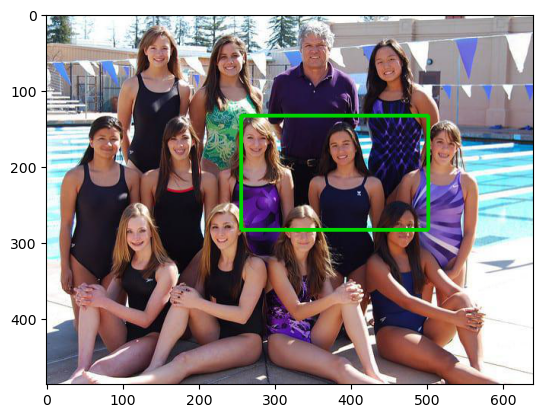

In [15]:
#  Viewing the bounding box for the detected face
img = Image.open(targetfilename)
imgWidth, imgHeight = img.size

draw = ImageDraw.Draw(img)
for faceRecord in response['FaceRecords']:
    box = faceRecord['Face']['BoundingBox']
    left = imgWidth * box['Left']
    top = imgHeight * box['Top']
    width = imgWidth * box['Width']
    height = imgHeight * box['Height']

    points = ((left, top), (left + width, top), (left + width, top + height),
              (left, top + height), (left, top))

    draw.line(points, fill='#00d400', width=5)

plt.imshow(img)
plt.show()


## Deleting the collection


In [ ]:
print('Attempting to delete collection ' + collection_id)
status_code=0
try:
    response=client.delete_collection(CollectionId=collection_id)
    status_code=response['StatusCode']
    print('All done!')
    print(status_code)
    
except ClientError as e:
    if e.response['Error']['Code'] == 'ResourceNotFoundException':
        print ('The collection ' + collection_id + ' was not found ')
    else:
        print ('Error other than Not Found occurred: ' + e.response['Error']['Message'])
    status_code=e.response['ResponseMetadata']['HTTPStatusCode']

